**References**

- [**Hands-on RL**](https://github.com/boyu-ai/Hands-on-RL/blob/main/%E7%AC%AC2%E7%AB%A0-%E5%A4%9A%E8%87%82%E8%80%81%E8%99%8E%E6%9C%BA%E9%97%AE%E9%A2%98.ipynb)


**Contents**
- Build Multi-Armed Bandit
- Build Basic Algorithm Framework

## Build Multi-Armed Bandit

In [1]:
## --------------------------------------------------------------------------------
## Multi-Armed Bandit
## --------------------------------------------------------------------------------
import numpy as np

SEED = 2025

class BernoulliBandit:
    """Build a Bernoulli bandit, input K as the number of arms"""
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # the probability of winning
        self.best_idx = np.argmax(self.probs)  # the arm with the highest winning probability
        self.best_prob = self.probs[self.best_idx]  # the highest winning probability
        self.K = K

    def step(self, k):
        # When the player selects the k-th arm, return 1 (winning) or 0 (not winning)
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(SEED)
K = 10
bandit_10_arm = BernoulliBandit(K)
print("A Bernoulli bandit with %d arms is generated" % K)
print("The arm with the highest winning probability is %d, and its winning probability is %.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))
## --------------------------------------------------------------------------------

A Bernoulli bandit with 10 arms is generated
The arm with the highest winning probability is 8, and its winning probability is 0.9642


## Build Basic Algorithm Framework

In [2]:
## --------------------------------------------------------------------------------
## Basic Algorithm Framework
## --------------------------------------------------------------------------------
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # the number of times each arm is pulled
        self.regret = 0.
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        # Calculate the cumulative regret, k is the selected arm
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # Return the selected arm, to be implemented by each specific strategy
        raise NotImplementedError

    def run(self, num_steps):
        # Run for a certain number of times, num_steps is the total number of runs
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)
## --------------------------------------------------------------------------------

In [3]:
## --------------------------------------------------------------------------------
## Epsilon-Greedy Algorithm
## --------------------------------------------------------------------------------
class EpsilonGreedy(Solver):
    """Epsilon-Greedy Algorithm"""
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)  # expected reward estimates

    def run_one_step(self):
        ## Randomly select an arm with probability epsilon
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        ## Otherwise, choose the arm with the highest estimated reward
        else:
            k = np.argmax(self.estimates)

        ## Get reward and update the estimated reward
        r = self.bandit.step(k)
        ## Below equals to: estimates[k] = ((estimates[k] * counts[k]) + r) / (counts[k] + 1)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        
        return k

epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01, init_prob=1.0)
epsilon_greedy_solver.run(5000)
## --------------------------------------------------------------------------------

In [4]:
## --------------------------------------------------------------------------------
## Decaying Epsilon Greedy
## --------------------------------------------------------------------------------
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon decays with time
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
## --------------------------------------------------------------------------------

In [5]:
## --------------------------------------------------------------------------------
## UCB Algorithm
## --------------------------------------------------------------------------------
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

UCB_solver = UCB(bandit_10_arm, coef=1, init_prob=1.0)
UCB_solver.run(5000)
## --------------------------------------------------------------------------------

In [6]:
## --------------------------------------------------------------------------------
## Thompson Sampling
## --------------------------------------------------------------------------------
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
## --------------------------------------------------------------------------------

C:\Users\junkunyuan\AppData\Local\Temp\ipykernel_31072\1042087880.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(solvers))


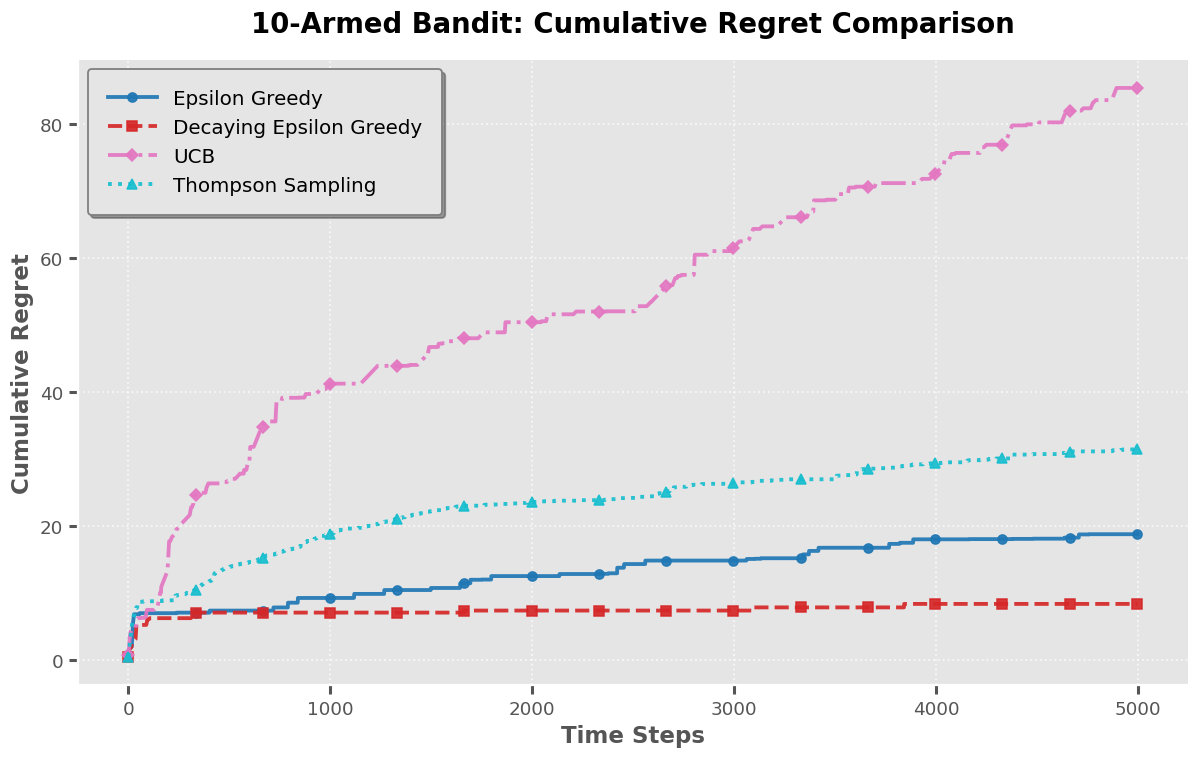

In [ ]:
## --------------------------------------------------------------------------------
## Plot Results
## --------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_results(solvers, solver_names):
    """Plot the cumulative regret over time with enhanced aesthetics (no seaborn)"""
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(11, 7), dpi=110)
    
    # Use a beautiful colormap from matplotlib
    colors = cm.get_cmap('tab10', len(solvers))
    linestyles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
    
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        ax.plot(
            time_list, solver.regrets, 
            label=solver_names[idx], 
            color=colors(idx),
            linewidth=2.5,
            linestyle=linestyles[idx % len(linestyles)],
            marker=markers[idx % len(markers)],
            markevery=int(len(time_list)/15),
            markersize=6,
            alpha=0.92
        )
    
    ax.set_xlabel('Time Steps', fontsize=15, fontweight='bold')
    ax.set_ylabel('Cumulative Regret', fontsize=15, fontweight='bold')
    ax.set_title(f"{solvers[0].bandit.K}-Armed Bandit: Cumulative Regret Comparison", fontsize=18, fontweight='bold', pad=18)
    
    # Beautify ticks and grid
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=2)
    ax.grid(True, linestyle=':', linewidth=1.2, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Legend with frame and shadow
    legend = ax.legend(
        frameon=True, fontsize=13, loc='upper left', 
        fancybox=True, shadow=True, borderpad=1, handlelength=2.5
    )
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(1.2)
    
    plt.tight_layout()
    plt.show()

solvers = [epsilon_greedy_solver, decaying_epsilon_greedy_solver, UCB_solver, thompson_sampling_solver]
solver_names = ["Epsilon Greedy", "Decaying Epsilon Greedy", "UCB", "Thompson Sampling"]
plot_results(solvers, solver_names)
## --------------------------------------------------------------------------------